In [36]:
import torch
import matplotlib.pyplot as plt
import h5py
import numpy as np
import seaborn as sns

In [37]:
# use LaTeX fonts in the plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 15})
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [38]:
# set the device
device = torch.device("cuda:0")

# load the data
with h5py.File("data/CMPC10.h5", "r") as f:
    data = torch.tensor(f["train"][()], device=device, dtype=torch.float32)
    labels = torch.tensor(f["train_labels"].asstr()[()].astype(int), device=device, dtype=int)
print(data.shape)

torch.Size([17832, 880])


In [39]:
# PCA
_, _, Vt = torch.svd(data - data.mean(dim=0))
data_proj = data @ Vt / data.shape[1]**0.5
data_proj = data_proj.cpu().numpy()

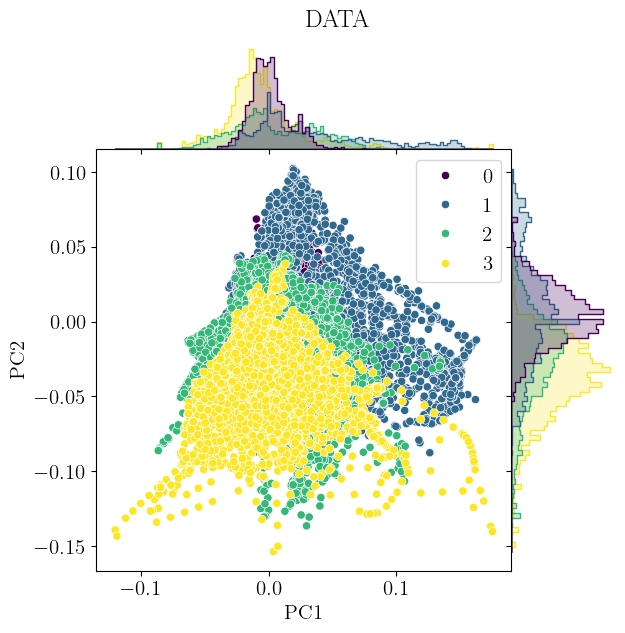

In [40]:
# Create a JointGrid for the scatter plot with histograms
g = sns.JointGrid(x=data_proj[:, 0], y=data_proj[:, 1], space=0, height=6, ratio=4)

# Add the scatter plot
g.plot_joint(sns.scatterplot, hue=labels.cpu().numpy(), palette='viridis')

# Add histograms on the top and right
g.plot_marginals(sns.histplot, kde=False, color='blue', stat='density', hue=labels.cpu().numpy(), palette='viridis', element='step')

# Set axis labels and title
g.set_axis_labels('PC1', 'PC2')
g.fig.suptitle('DATA', y=1.02)

# take the x and y limits of the scatter plot
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()

plt.show()

In [41]:
# Import FeF model
import importlib
import sys
sys.path.append("src/RBMs")
RBM = importlib.import_module("BernoulliBernoulliSslRBM").RBM
rbm = RBM(device=device)

path_model = "/home/lorenzo.rosset/FeF/models/FeF-CMPC-Nh200.h5"

# Print the saved epochs
with h5py.File(path_model, "r") as f:
    saved_epochs = []
    for k in f.keys():
        if "W" in k:
            saved_epochs.append(int(k.replace("W", "")))
saved_epochs = sorted(saved_epochs)
print(saved_epochs)

[1, 2, 4, 7, 13, 22, 36, 61, 103, 173, 290, 485, 813, 1361, 2279, 3816, 6390, 10700, 17916, 30000]


In [42]:
rbm.loadRBM(path_model, stamp=2279)

In [43]:
# Sample from the model  conditioned on the labels
rand_init = torch.randint(0, 2, data.shape, device=device, dtype=torch.float32)
gen, *_ = rbm.conditioned_sampling(rand_init, labels)

In [44]:
# Project the generated data
gen_proj = gen @ Vt / data.shape[1]**0.5
gen_proj = gen_proj.cpu().numpy()

(-0.1666443046182394, 0.11507355384528636)

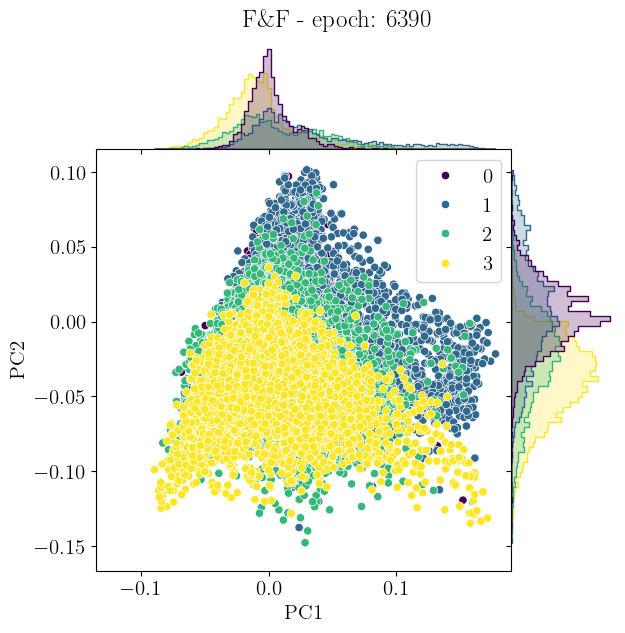

In [45]:
# Plot the generated data in the same scatter plot
g = sns.JointGrid(x=gen_proj[:, 0], y=gen_proj[:, 1], space=0, height=6, ratio=4)
g.plot_joint(sns.scatterplot, hue=labels.cpu().numpy(), palette='viridis')
g.plot_marginals(sns.histplot, kde=False, color='red', stat='density', hue=labels.cpu().numpy(), palette='viridis', element='step')
g.set_axis_labels('PC1', 'PC2')
g.fig.suptitle('F\&F - epoch: 6390', y=1.02)
# Set the same limits as the scatter plot of the data
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)

In [22]:
# Now generate using PCD
path_model_pcd = "/home/lorenzo.rosset/FeF/models/PCD-CMPC.h5"
rbm_pcd = RBM(device=device)
rbm_pcd.loadRBM(path_model_pcd)

In [27]:
# Sample from the model  conditioned on the labels
it_mcmc = 100000
rand_init = torch.randint(0, 2, data.shape, device=device, dtype=torch.float32)
gen_pcd, *_ = rbm_pcd.conditioned_sampling(rand_init, labels, it_mcmc=it_mcmc)

In [28]:
# Project the generated data
gen_proj_pcd = gen_pcd @ Vt / data.shape[1]**0.5
gen_proj_pcd = gen_proj_pcd.cpu().numpy()

(-0.1666443046182394, 0.11507355384528636)

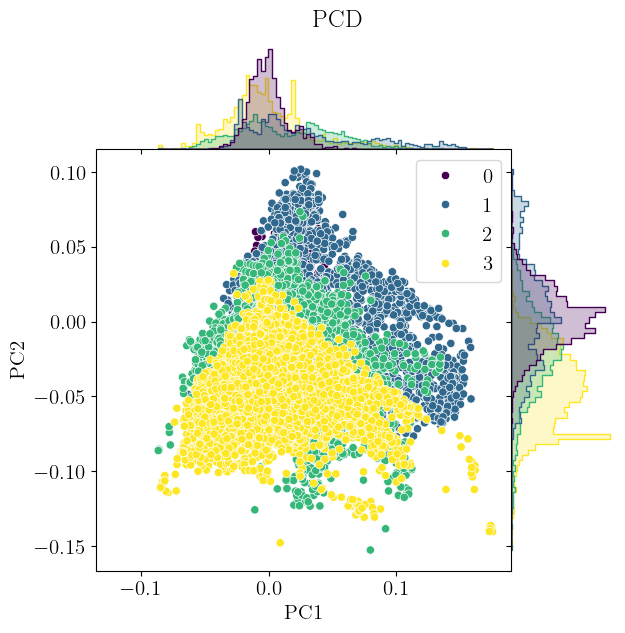

In [34]:
# Plot the generated data in the same scatter plot
g = sns.JointGrid(x=gen_proj_pcd[:, 0], y=gen_proj_pcd[:, 1], space=0, height=6, ratio=4)
g.plot_joint(sns.scatterplot, hue=labels.cpu().numpy(), palette='viridis')
g.plot_marginals(sns.histplot, kde=False, color='red', stat='density', hue=labels.cpu().numpy(), palette='viridis', element='step')
g.set_axis_labels('PC1', 'PC2')
g.fig.suptitle('PCD', y=1.02)
g.ax_joint.set_xlim(xlim)
g.ax_joint.set_ylim(ylim)

In [35]:
g.savefig("/home/lorenzo.rosset/FeF/results/images/scatter_PCD_100k.svg")